In [1]:
%load_ext autoreload
%autoreload 2
from hmpai.pytorch.utilities import *
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.normalization import *
from hmpai.visualization import *
from pathlib import Path
import xarray as xr
from hmpai.data import preprocess
from captum.attr import IntegratedGradients
from mne.io import read_info

In [2]:
set_global_seed(42)
data_path = Path("../data/sat2/split_stage_data.nc")
dataset = xr.load_dataset(data_path)
train_data, val_data, test_data = split_data_on_participants(
    dataset, 60, norm_min1_to_1
)
positions = read_info(Path("../data/sat1/preprocessed/processed_0001_epo.fif"))

In [3]:
chk_path = Path("../models/transformer100_sat2/checkpoint.pt")
checkpoint = load_model(chk_path)

# RNN cannot be used in eval mode with cuDNN enabled
torch.backends.cudnn.enabled = True
model_kwargs = {
    "n_features": len(train_data.channels),
    "n_heads": 10,
    "ff_dim": 512,
    "n_layers": 6,
    "n_samples": len(train_data.samples),
    "n_classes": len(train_data.labels),
}
model = TransformerModel(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(DEVICE).eval()

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
        )
        (linear1): Linear(in_features=30, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=30, bias=True)
        (norm1): LayerNorm((30,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((30,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=30, out_features=5, bias=True)
  (linear): Linear(in_features=30, out_features=30, bias=True)
)

In [9]:
chk_path = Path("../models/gru100_sat2/checkpoint.pt")
checkpoint = load_model(chk_path)
# RNN cannot be used in eval mode with cuDNN enabled
torch.backends.cudnn.enabled = False
model_kwargs = {
    "n_channels": len(train_data.channels),
    "n_samples": len(train_data.samples),
    "n_classes": len(train_data.labels),
}
model = SAT1GRU(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(DEVICE).eval()

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


SAT1GRU(
  (relu): ReLU()
  (gru): GRU(30, 256, batch_first=True)
  (linear): LazyLinear(in_features=0, out_features=128, bias=True)
  (linear_final): LazyLinear(in_features=0, out_features=5, bias=True)
)

In [14]:
chk_path = Path("../models/cnn100_sat2/checkpoint.pt")
checkpoint = load_model(chk_path)
# RNN cannot be used in eval mode with cuDNN enabled
torch.backends.cudnn.enabled = True
model_kwargs = {
    "n_classes": len(train_data.labels),
}
model = SAT1Base(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(DEVICE).eval()

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


SAT1Base(
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=128, bias=True)
  (linear_final): LazyLinear(in_features=0, out_features=5, bias=True)
  (maxpool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv1): PartialConv2d(1, 64, kernel_size=(5, 1), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 1), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 1), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
)

In [4]:
del dataset

In [15]:
ig = IntegratedGradients(model.forward)

In [16]:
attributions = add_attribution(test_data, ig, model)

  0%|          | 0/290 [00:00<?, ?it/s]

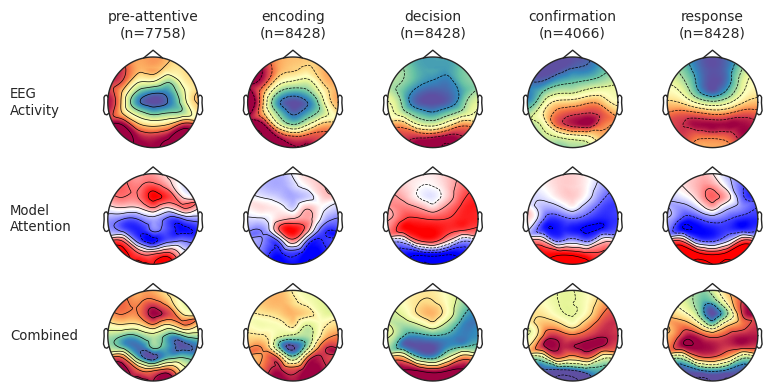

In [17]:
plot_max_activation_per_label(attributions, positions, save=True)

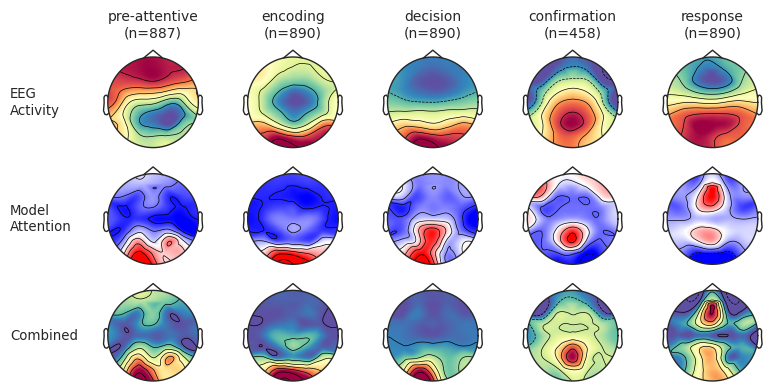

In [31]:
plot_max_activation_per_label(attributions, positions, save=True)

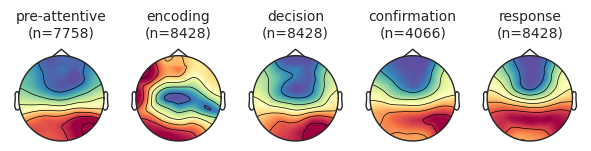

In [11]:
plot_mean_activation_per_label(attributions, positions)

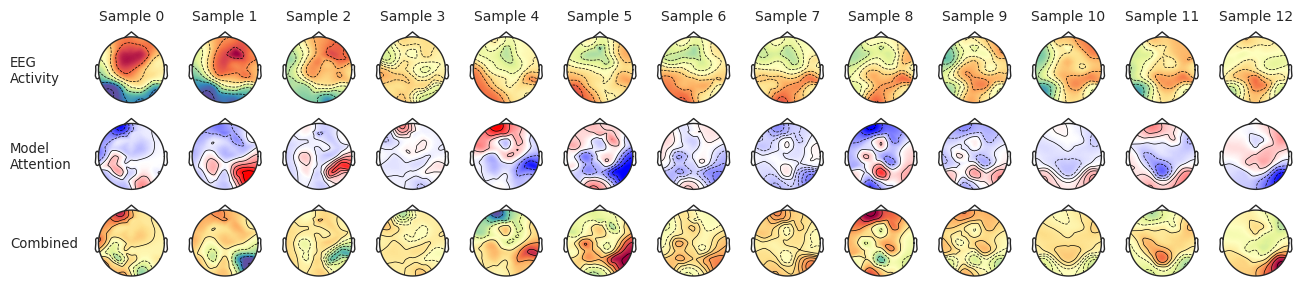

In [12]:
plot_single_trial_activation(attributions.isel(index=1), positions)

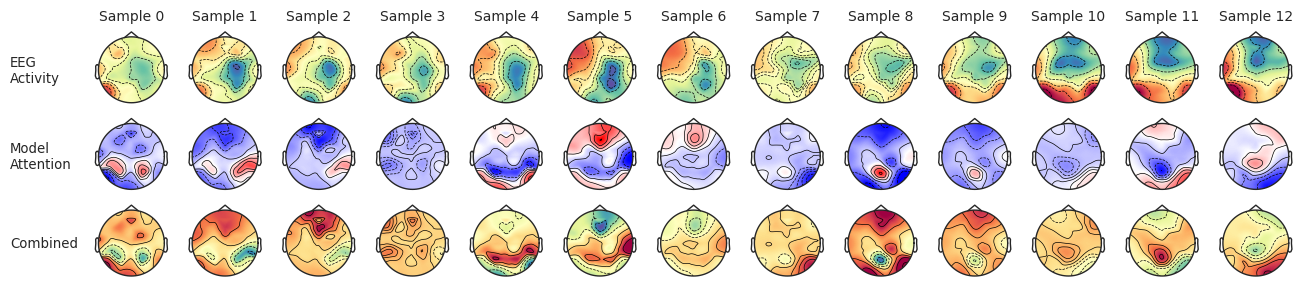

In [13]:
plot_single_trial_activation(attributions.isel(index=3), positions)

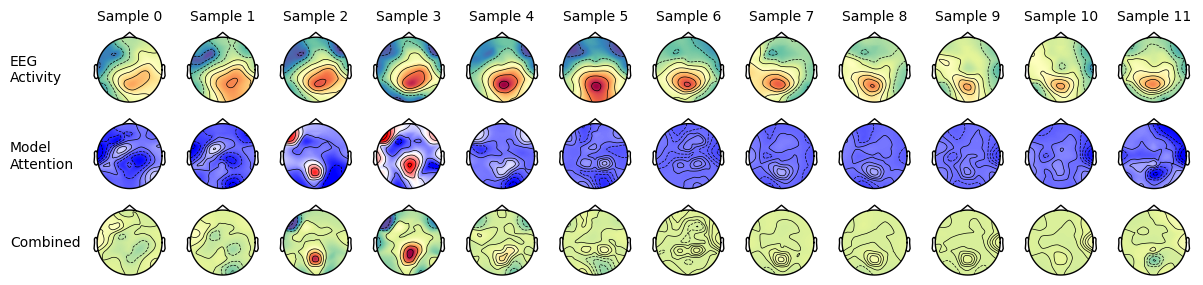

In [20]:
plot_single_trial_activation(attributions.isel(index=5), positions)

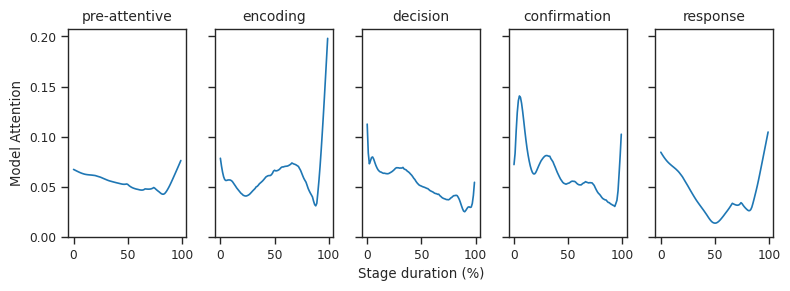

In [18]:
plot_model_attention_over_stage_duration(attributions, save=True)